In [2]:
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from IPython.display import Audio

# Fonte do arquivo de som: https://freesound.org/people/CVLTIV8R/sounds/800700/

# Compressão sem perdas em áudio

As redes de streaming dependem do uso eficiente de dados - se não pela velocidade de conexão, ao menos pela necessidade de economizar planos de dados. Por esse motivo, a compressão de áudio foi um grande tema de pesquisa até que ela culminou na invenção da MP3. Apesar da MP3 já ter algumas décadas de existência, não há hoje nenhuma tecnologia que supere a taxa de compressão e a qualidade obtida por ela.

## Áudio analógico para digital

Um som, tocando ao vivo, vem de uma onda sonora. Uma onda sonora é uma pequena oscilação na pressão do ar, que se propaga como as ondas do mar. A onda sonora agita nossos tímpanos, que estimulam uma série de mecanismos internos do ouvido, e, depois, isso se converte em um sinal elétrico que vai para nosso cérebro. Por fim, nosso cérebro interpreta aquele estímulo como um "som".

Você provavelmente já percebeu que nós não transmitimos ondas sonoras através da Internet. Ao invés disso, transmitimos *bits*. Então, para que um "som" apareça no seu computador ou no seu celular, ele deve antes ser convertido em uma cadeia de bits.

Essa conversão acontece através de um processo chamado *amostragem*. No processo de amostragem, as pequenas oscilações de pressão do ar que se propagam antes de se tornar "som" são convertidas em sinais elétricos através de um sensor chamado *microfone*. Depois disso, os sinais elétricos são convertidos para bytes através de um periférico chamado *conversor analógico-digital*.

O conversor analógico-digital (ou: ADC, de *analog-digital converter*) opera tirando pequenas "fotos" do valor de tensão recebido em sua entrada. Daí, começamos a ter várias "fotos" que vamos chamar de $x_1$, $x_2$, etc., da seguinte forma:

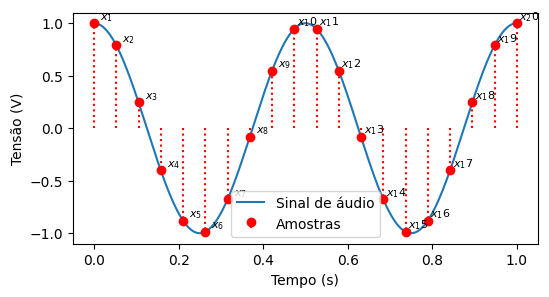

In [3]:
t = np.linspace(0, 1, 1000)
ts = np.linspace(0, 1, 20)

x = np.cos(2*np.pi*2*t)
xs = np.cos(2*np.pi*2*ts)

plt.figure(figsize=(6,3))
plt.plot(t, x, label="Sinal de áudio")
plt.ylabel('Tensão (V)')
plt.xlabel('Tempo (s)')
markerline, stemlines, baseline = plt.stem(ts, xs, markerfmt='r', linefmt='r:', basefmt=' ', label="Amostras")


for i, (tx, val) in enumerate(zip(ts, xs), 1):
    plt.text(tx+0.03, val, f'$x_{i}$', ha='center', va='bottom', fontsize=8)
plt.legend()
plt.show()


Então, nosso sinal de áudio, que estava originalmente oscilando pelo ar, passou a ser representado como uma *sequência de números*. Bem, se é uma sequência de números, podemos representá-lo como um vetor $x_t$:


$$
x = \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix}
$$

!!! info "Taxa de Amostragem"
    A frequência de "fotos" que tiramos de nosso sinal é chamada de Taxa de Amostragem, ou Sampling Frequency. Ela funciona de modo análogo ao *frame rate* em jogos. Cada uma das "fotos" é chamada de "amostra". Claro que gostaríamos de taxas de amostragem mais altas, mas isso também implicaria em ter muito mais amostras para armazenar, da mesma forma que gostamos de fotos com mais megapixels ou filmes com mais quadros por segundo. Por outro lado, se tivermos poucas amostras, vamos começar a ouvir artefatos, que são análogos a quando começamos ver fotos de baixa resolução (pixeladas) ou um filme a poucos quadros por segundo e passamos a ver os quadros isolados ao invés de uma sequência contínua.

??? info "Se minha taxa de amostragem é de 100 Hz e eu tenho 300 amostras, quantos segundos tem minha gravação?"
    São 100 amostras por segundo, e, portanto, 300 amostras correspondem a 3 segundos.

??? info "Se minha taxa de amostragem é de 48kHz, quantas amostras deve ter uma gravação de 1.5 segundos?"
    Em 1 segundo, tenho 48 mil amostras. Em 1.5 segundo, tenho 48+24=76 mil amostras.

## Abrindo um arquivo de áudio

Um arquivo com dados de áudio tem tipicamente duas partes: um cabeçalho com informações gerais e um segmento de dados (o maior segmento) que tem as amostras $x_1$, $x_2$, etc.

Podemos ouvir nossa gravação:

In [4]:
fname = 'guitar.wav'
Audio(filename=fname)

Para abrir um arquivo de áudio, tipicamente usamos uma biblioteca como `soundfile`. A função `sf.info` encontra as informações do cabeçalho de um arquivo de áudio:

In [5]:
info = sf.info(fname)
print(info)

guitar.wav
samplerate: 96000 Hz
channels: 2
duration: 3.751 s
format: WAV (Microsoft) [WAV]
subtype: 32 bit float [FLOAT]


!!! info "Taxas de amostragem e canais"
    Veja que, nesse caso, temos uma taxa de amostragem de 96kHz e 2 canais. Os canais correspondem ao som que deve ser colocado em cada um dos "canais de saída". Neste caso, temos 2 canais, isto é, trata-se de um som estéreo. Poderíamos ter, também, sons mono (1 canal) ou multi-canal, que são feitos para equipamentos como home theaters.

Vamos agora ler os conteúdos do arquivo de áudio. Para iso, usamos `sf.read`, que retorna duas variáveis:

* `x`, que é o conteúdo das amostras gravadas, e
* `sr`, que contém a taxa de amostragem da gravação:

In [6]:
x, sr = sf.read(fname)
print(sr)

96000


Veja como `sr` corresponde à taxa de amostragem que foi informada em `sf.info`!

Vamos agora analisar a variável `x`:

In [7]:
print(type(x))
print(x.shape)

<class 'numpy.ndarray'>
(360072, 2)


A variável `x`, portanto, é um `np.array` com muitas linhas, e duas colunas. Cada uma das colunas corresponde a um canal, e cada uma das linhas corresponde a uma amostra. Mas, por que temos esse número exato de amostras? Veja só:

In [8]:
print(info.samplerate * info.duration)

360072.0


Isso se parece com uma conta que você já fez, não?

### Plotando um arquivo de áudio

Até o momento, temos um sinal de áudio de dois canais. Eles correspondem ao canal da esquerda ($x^(e)$) e da direita ($x^{(d)}$) isto é:

$$
x = \begin{bmatrix} \vert & \vert \\ x^{(e)} & x^{(d)} \\ \vert & \vert \end{bmatrix}
$$

Gostaríamos de trabalhar com um canal único, porque o processamento que vamos fazer é estritamente o mesmo para ambos os canais. Uma maneira de fazer isso é simplesmente escolher o primeiro canal:

In [9]:
xe = x[:,0]

E agora, podemos mostrar nossa onda sonora:

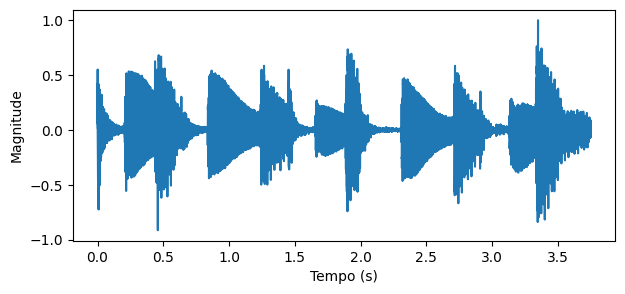

In [10]:
t = np.arange(len(xe)) / sr
plt.figure(figsize=(7,3))
plt.plot(t, xe)
plt.xlabel('Tempo (s)')
plt.ylabel('Magnitude')
plt.show()

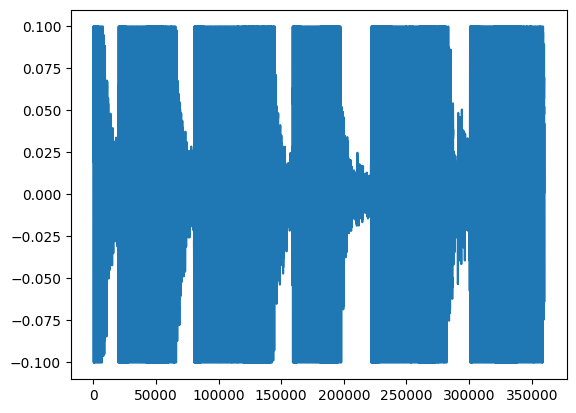

In [50]:
xe = np.minimum(xe, 0.1)
xe = np.maximum(xe, -0.1)
plt.plot(xe)

In [51]:
Audio(data=xe, rate=sr)

## Quantização

Lembre-se que nosso assunto principal aqui é a compressão. Vamos trabalhar com a compressão sem perdas em áudio. Para isso, vamos começar com a seguinte ideia: vamos *quantizar* nossas amostras, isto é, vamos transformá-las todas em números inteiros num intervalo. Ao *quantizar* as amostras, passamos a ter um vocabulário finito de valores possíveis para nossas amostras.

Se temos um vocabulário finito de valores sendo usados para representar cada amostra, isso significa que cada um desses valores pode corresponder a um símbolo ($s_1$, $s_2$, etc.) de um vocabulário. Mas, veja só na figura como os valores próximos de zero são muito mais comuns que os valores mais distantes de zero.

??? info "Se temos uma sequência de símbolos na qual alguns símbolos ocorrem muito mais vezes que outros, qual algoritmo podemos usar para comprimir a sequência?"
    Podemos usar o Código de Huffman!

Então, podemos começar nosso processo de compressão com a função:

In [11]:
def quantizar(x : np.ndarray, n : int):
    x = x - x.min()
    x = x / x.max()
    x = x * n
    x = x.astype(int)
    return(x)

### Visualizando a quantização

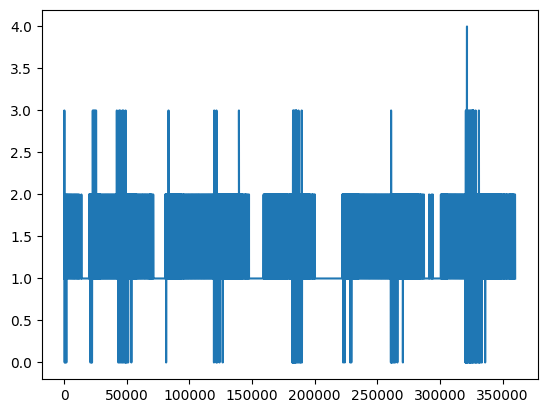

In [28]:
xeq = quantizar(xe, 2**2)
plt.plot(xeq)

In [21]:
Audio(data=xeq, rate=sr)


In [22]:
xeq[0:10]

array([2095013879, 2113584148, 2120691028, 2130735276, 2136260005,
       2149567632, 2155897826, 2171251058, 2184526726, 2196197867])

Após, aplique o Código de Huffman para comprimir sua cadeia. Qual taxa de compressão você conseguiu?

In [37]:
def no_vazio():    
    node = {
        'conteudo' : None,
        'filho_esquerdo' : None,
        'filho_direito' : None
    }
    return node

def contar_ocorrencias_unicas(s : str):
    caracteres_unicos = {}
    for idx in range(len(s)):
        if s[idx] in caracteres_unicos.keys():
            caracteres_unicos[s[idx]] += 1
        else:
            caracteres_unicos[s[idx]] = 1
    return caracteres_unicos

def dict_to_tuple(d : dict):
    list_of_tuples = []
    for k in d.keys():
        no = no_vazio()
        no['conteudo'] = [k]
        t = (no, d[k])
        list_of_tuples.append(t)
    return list_of_tuples

def get_count(t):
    return t[1]

def remover_dois_elementos(lista_de_tuplas):
    e1 = lista_de_tuplas[0]
    e2 = lista_de_tuplas[1]
    lista_de_tuplas_ = lista_de_tuplas[2:]
    return e1, e2, lista_de_tuplas_

def juntar_dois_elementos(e1, e2):
    novo_conteudo = e1[0]['conteudo'] + e2[0]['conteudo']
    no = no_vazio()
    no['conteudo'] = novo_conteudo
    no['filho_esquerdo'] = e1[0]
    no['filho_direito']  = e2[0]
    contagem = e1[1] + e2[1]
    return (no, contagem)

def arvore_de_huffman(s : str):
    ocorrencias = contar_ocorrencias_unicas(s)
    tuplas = dict_to_tuple(ocorrencias)
    while len(tuplas) > 1:
        tuplas = sorted(
            tuplas,
            key=get_count,
        )
        e1, e2, tuplas = remover_dois_elementos(tuplas)
        e_novo = juntar_dois_elementos(e1, e2)
        tuplas.append(e_novo)
    return e_novo

def codificar(no_pai, c):

    if no_pai['filho_esquerdo'] is None:
        codigo = ''
    elif c in no_pai['filho_esquerdo']['conteudo']:
        codigo = '1' + codificar(no_pai['filho_esquerdo'], c)
    elif c in no_pai['filho_direito']['conteudo']:
        codigo = '0' + codificar(no_pai['filho_direito'], c)
    return codigo

def codificar_string(no_pai, s):
    codigo = ''
    for c in s:
        codigo = codigo + codificar(no_pai, c)
    return codigo

def decodificar_string(no_pai, s_cod):
    no_atual = no_pai
    saida = []
    for i in range(len(s_cod)):
        if s_cod[i] == '1':
            no_atual = no_atual['filho_esquerdo']
        elif s_cod[i] == '0':
            no_atual = no_atual['filho_direito']        
        if no_atual['filho_esquerdo'] is None:
            saida.append(no_atual['conteudo'][0])
            no_atual = no_pai
    return saida

In [38]:
from pprint import pprint
arvore = arvore_de_huffman(list(xeq))[0]
pprint(arvore)

{'conteudo': [np.int64(4), np.int64(3), np.int64(0), np.int64(2), np.int64(1)],
 'filho_direito': {'conteudo': [np.int64(1)],
                   'filho_direito': None,
                   'filho_esquerdo': None},
 'filho_esquerdo': {'conteudo': [np.int64(4),
                                 np.int64(3),
                                 np.int64(0),
                                 np.int64(2)],
                    'filho_direito': {'conteudo': [np.int64(2)],
                                      'filho_direito': None,
                                      'filho_esquerdo': None},
                    'filho_esquerdo': {'conteudo': [np.int64(4),
                                                    np.int64(3),
                                                    np.int64(0)],
                                       'filho_direito': {'conteudo': [np.int64(0)],
                                                         'filho_direito': None,
                                                      

In [39]:

codigo = codificar_string(arvore, list(xeq))
print(codigo)


0000010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101110101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101001010101010101010101010101010101010101000001010100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000110000000000000000000000000000000000000000000001010101000000000000000000000000000000000101010101000000101010100001010101010101010101010101010101010101010100000101010000000101010101000010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101

In [ ]:
tamanho_original = len(xeq) // 4
tamanho_codificado = len(codigo)//8

print(tamanho_original, tamanho_codificado, tamanho_codificado/tamanho_original)

90018 60974 0.6773534182052479


In [ ]:
recuperado = decodificar_string(arvore, codigo)

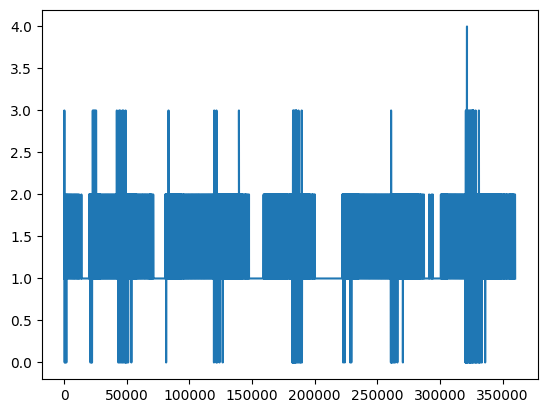

In [41]:
plt.plot(recuperado)

In [49]:
for n in range(2,16):
    xeq = quantizar(xe, 2**n)
    arvore = arvore_de_huffman(list(xeq))[0]
    codigo = codificar_string(arvore, list(xeq))
    tamanho_original = len(xeq)*n//8
    tamanho_codificado = len(codigo)//8
    print(f"Com {n} bits: {tamanho_codificado/tamanho_original}")

Com 2 bits: 0.6773534182052479
Com 3 bits: 0.5567405037511016
Com 4 bits: 0.6291408384989668
Com 5 bits: 0.6845519784931903
Com 6 bits: 0.7360379775896673
Com 7 bits: 0.7709442238536419
Com 8 bits: 0.7986708213912773
Com 9 bits: 0.8206729024565458
Com 10 bits: 0.838410095758626
Com 11 bits: 0.8528779092666315
Com 12 bits: 0.8647825990357484
Com 13 bits: 0.8746302021646952
Com 14 bits: 0.8825933226053202


KeyboardInterrupt: 